In [1]:
import os
import pickle
import numpy as np
import pandas as pd

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wesad-3labels/3_labels.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout, Dense, Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

2024-03-12 13:17:00.777633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 13:17:00.777774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 13:17:00.902440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load your merged dataset
merged_data = pd.read_csv(r"/kaggle/input/wesad-3labels/3_labels.csv")

# Assuming the last column contains the target labels
X = merged_data.iloc[:, :-1].values
y = merged_data.iloc[:, -1].values

# Reshape the input data to fit the Conv1D model
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)




In [6]:
# Create the model outside the loop
model = Sequential()

# CNN layers
model.add(Conv1D(filters=128, kernel_size=3, activation='relu' , input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
# model.add(Flatten())

# GRU layers with dropout
model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model only once
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=1024, validation_data=(X_val, y_val))

Epoch 1/15
36687/36687 ━━━━━━━━━━━━━━━━━━━━ 466s 12ms/step - accuracy: 0.9103 - loss: 0.2159 - val_accuracy: 0.9759 - val_loss: 0.0617
Epoch 2/15
36687/36687 ━━━━━━━━━━━━━━━━━━━━ 462s 13ms/step - accuracy: 0.9710 - loss: 0.0760 - val_accuracy: 0.9760 - val_loss: 0.0620
Epoch 3/15
36687/36687 ━━━━━━━━━━━━━━━━━━━━ 461s 13ms/step - accuracy: 0.9764 - loss: 0.0618 - val_accuracy: 0.9831 - val_loss: 0.0423
Epoch 4/15
36687/36687 ━━━━━━━━━━━━━━━━━━━━ 461s 13ms/step - accuracy: 0.9794 - loss: 0.0538 - val_accuracy: 0.9862 - val_loss: 0.0343
Epoch 5/15
36687/36687 ━━━━━━━━━━━━━━━━━━━━ 462s 13ms/step - accuracy: 0.9812 - loss: 0.0491 - val_accuracy: 0.9758 - val_loss: 0.0594
Epoch 6/15
36687/36687 ━━━━━━━━━━━━━━━━━━━━ 463s 13ms/step - accuracy: 0.9826 - loss: 0.0455 - val_accuracy: 0.9850 - val_loss: 0.0374
Epoch 7/15
36687/36687 ━━━━━━━━━━━━━━━━━━━━ 463s 13ms/step - accuracy: 0.9836 - loss: 0.0429 - val_accuracy: 0.9865 - val_loss: 0.0344
Epoch 8/15
36687/36687 ━━━━━━━━━━━━━━━━━━━━ 463s 13ms/s

In [8]:
model.save("model_filename.keras")
print(f"Saved model")

Saved model


In [9]:
# Evaluate the model and print the classification report
from sklearn.metrics import classification_report
predict_x=model.predict(X_test)
y_pred=np.argmax(predict_x,axis=1)
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
from sklearn.metrics import roc_curve, auc, roc_auc_score


234794/234794 ━━━━━━━━━━━━━━━━━━━━ 459s 2ms/step
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99   4425342
         1.0       0.99      1.00      0.99   1972052
         2.0       0.97      0.98      0.98   1116014

    accuracy                           0.99   7513408
   macro avg       0.99      0.99      0.99   7513408
weighted avg       0.99      0.99      0.99   7513408



Confusion Matrix for:



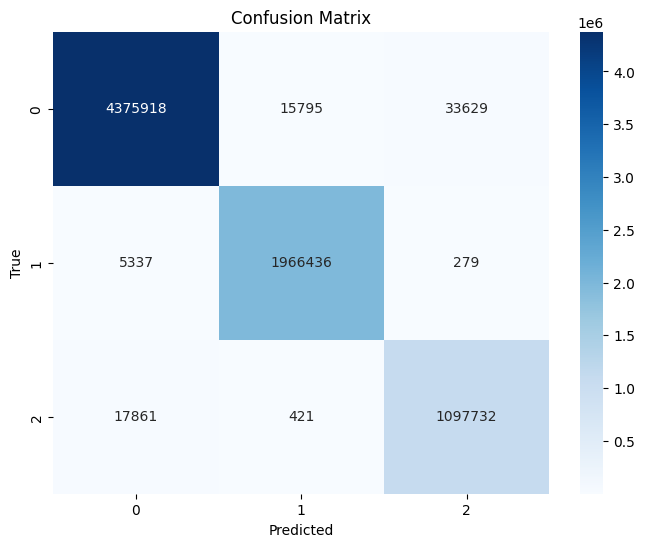

ROC for :



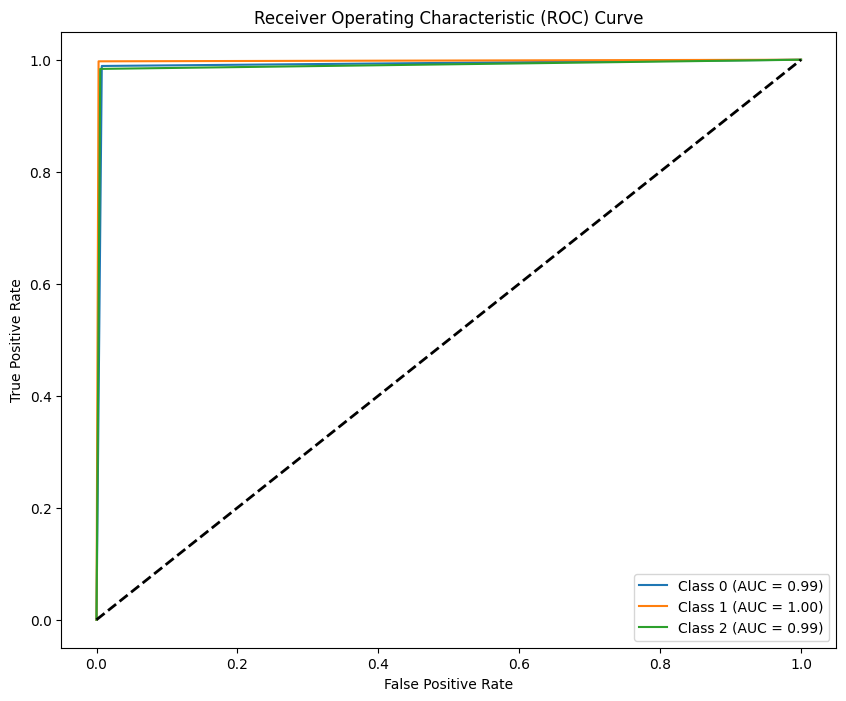

Training and Validation Curves


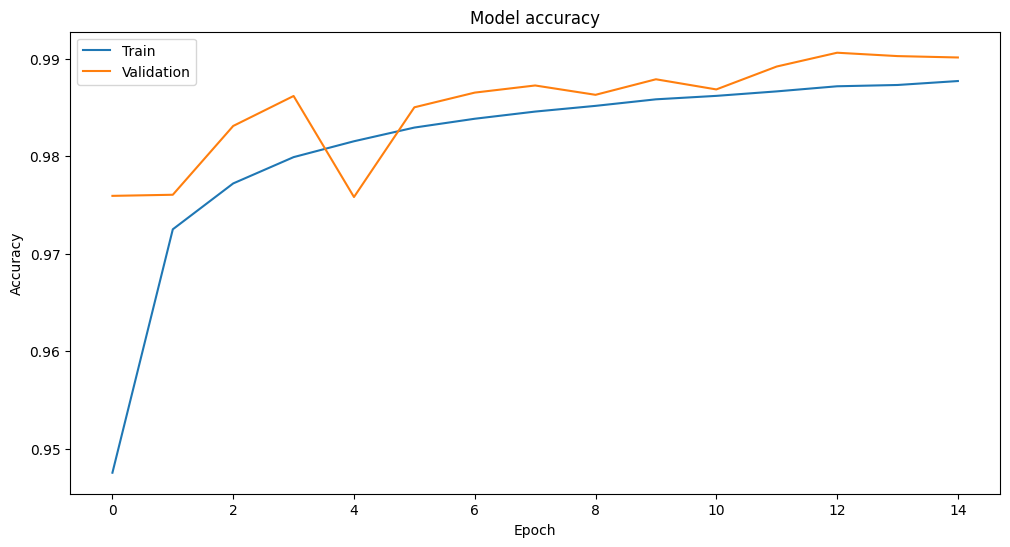

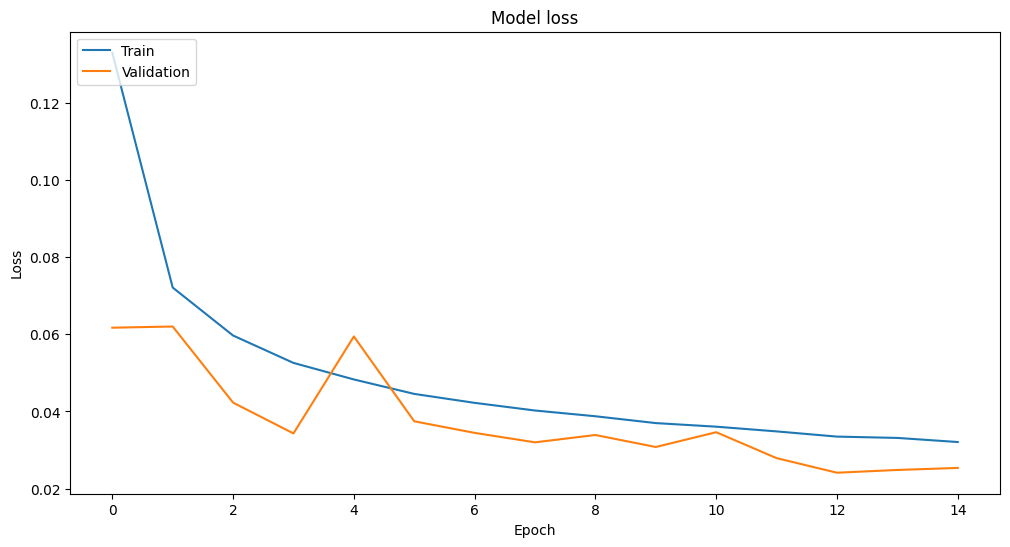

In [10]:

print(f"Confusion Matrix for:\n")
def plot_confusion_matrix(y_true, y_pred, classes):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

# Plot the confusion matrix
y_pred_prob = predict_x
y_pred = np.argmax(y_pred_prob, axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['0', '1', '2'])
# Compute ROC curve and ROC area for each class
print(f"ROC for :\n")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
n_classes = 3
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = label_binarize(y_pred, classes=np.arange(n_classes))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Training and Validation Curves")
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9902411795020316
